# **Astro 160 Fall 2020 Essential Pieces of Code v.2**
## *Hunter Hall — hall@berkeley.edu — November 1, 2020*
### Edited by Ziyi Lu, Oct 2020

##### *These are simply taken from some of my lab assignments during the Fall of 2019. Feel free to make any edits you'd like to them, but when doing so, please make a new cell below the original code so that we can see why we edited the original as we did. - Hunter*

##### Formated for consistency & clarity. Added additional comments & edited some for precision.
Optimised code, esp. unnecessary append()s, where assignment should be used. They take so much more time & space. -Ziyi

In [22]:
#Import all important packages
import matplotlib.pyplot as plt
import numpy as np
import glob

# Settings below only apply for Jupyter
#This make plots inline
%matplotlib inline
#This increases image resolution
%config InlineBackend.figure_format = 'retina'

# 1.0 **Importing .txt or .csv Files**
## *Linked below are files from Hunter's 2019 datasets from Labs 1 and 2 that are used in this example — note that the glob function wasn't necessarily used in Lab 1, but that it still works for .csv and .txt files:* 
https://drive.google.com/file/d/1ZeIZHzrKRpZVqp-3zwkk0u72AKEZX2AN/view?usp=sharing

## 1.1 Importing One File

In [23]:
# Navigate to raw data
#--------------------------------------#
lab1_data_path = 'example_data/lab1_pmt_data/lab1_data_10k_.8b_1r.csv'
#--------------------------------------#


# Import data
#--------------------------------------#
DELIMITER = ','
DTYPE = 'int32'

lab1_data = np.loadtxt(lab1_data_path, delimiter=DELIMITER, dtype=DTYPE)
#--------------------------------------#


# Obtains an array of useful data (time-stamps)
#--------------------------------------#
time_step = lab1_data[:,1]
#--------------------------------------#


# Displays the final output we've made
#--------------------------------------#
print(time_step)
#--------------------------------------#

[907536784 922749663 922750970 ... 753463664 766107459 770382781]


## 1.2 Importing Multiple Files with *glob*

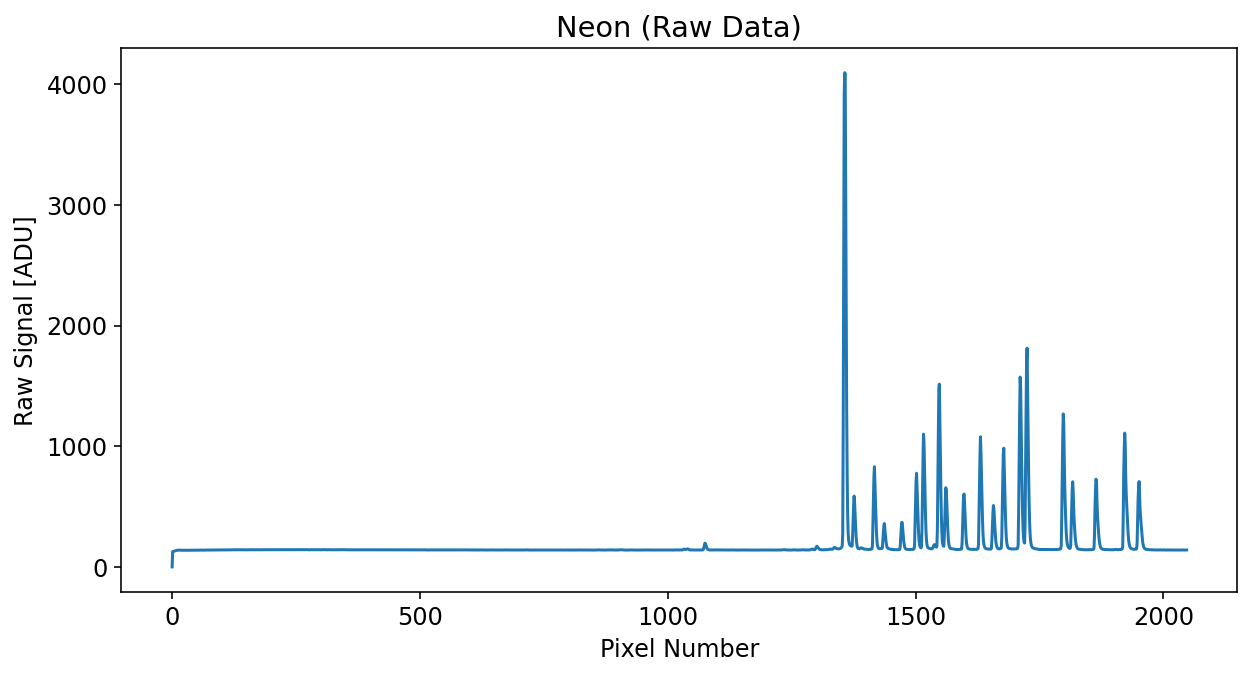

In [25]:
# Function
#--------------------------------------#
def get_signal_optimal(file_path):
    '''
    Reads signals from a file at FILE_PATH generated by a 1D CCD.
    This one replaces append()s w/ assignments to save time & space.
    '''
    # These constants better b defined at start of the whole code
    CCD_PIXELS = 2048
    LENGTH_HEADER = 17
    LENGTH_FOOTER = 1
    
    pixel = np.arange(0, CCD_PIXELS)
    
    files = glob.glob(file_path)
    n_files = len(files)
    signal = np.zeros((n_files, CCD_PIXELS)) # An empty 2D array of zeros
    
    for i in range(n_files):
        pixNum, s = np.genfromtxt(files[i], dtype=(float), skip_header=LENGTH_HEADER, skip_footer=LENGTH_FOOTER, unpack=True)
        signal[i] = s
    return(pixel, signal)
#--------------------------------------#


# Navigate to raw data
#--------------------------------------#
lab2_file_path = 'example_data/lab2_neon_data/*.txt'
#--------------------------------------#


# Import data by executing function
#--------------------------------------#
pixel, signal = get_signal_optimal(lab2_file_path)
#--------------------------------------#


# Average files in the dataset
#--------------------------------------#
signal_avg_neon = np.mean(signal, axis=0)
#--------------------------------------#


# Plotting
#--------------------------------------#
plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 12})
plt.plot(pixel,signal_avg_neon)
plt.title('Neon (Raw Data)')
plt.xlabel('Pixel Number')
plt.ylabel('Raw Signal [ADU]')
plt.show()
#--------------------------------------#

# 2.0 **Peak Finding and Centroiding**
## *The data used in this section is the same data from section 1.0* 

## 2.1 1D Peak Finding Algorithm

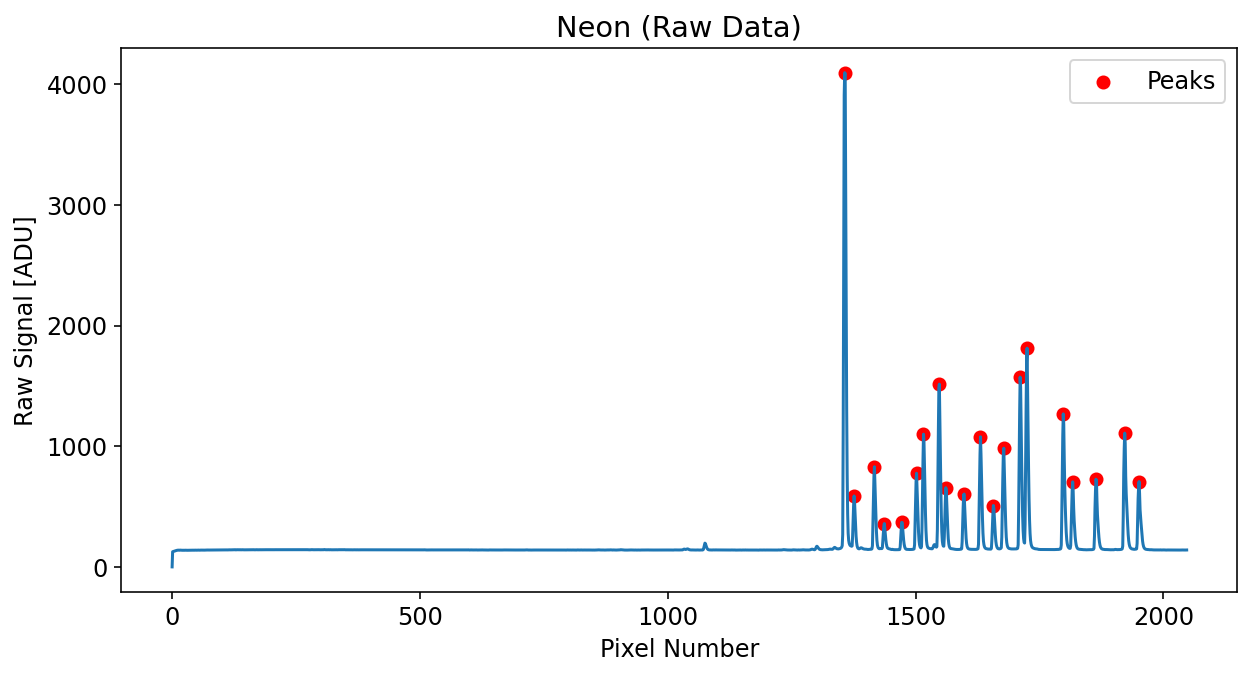

In [26]:
# Peak finding function
#--------------------------------------#
def peak_finding(signal_threshold_minimum, signal_data):
    signal_peaks = []
    signal_peaks_index = [] # x positions of the peaks, or rather, their index
    for i in range(len(signal_data) - 1): #len(signal)-1 because you will be checking the value after than your last i 
        if (signal_threshold_minimum <= signal_data[i]) \
            and (signal_data[i - 1] <= signal_data[i]) \
            and (signal_data[i] >= signal_data[i + 1]):  #three conditions to be a peak 
            signal_peaks.append(signal_data[i])
            signal_peaks_index.append(i)
    return signal_peaks_index, signal_peaks
#--------------------------------------#


# Calling the function
#--------------------------------------#
neon_peaks_index, neon_peaks = peak_finding(200, signal_avg_neon)
#--------------------------------------#


# Plotting
#--------------------------------------#
plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 12})
plt.plot(pixel, signal_avg_neon)
plt.scatter(neon_peaks_index, neon_peaks, color='red', marker='o', label='Peaks')
plt.title('Neon (Raw Data)')
plt.xlabel('Pixel Number')
plt.ylabel('Raw Signal [ADU]')
plt.legend()
plt.show()
#--------------------------------------#

## 2.2 1D Centroiding
### *Tutorial I followed during 2019 to help make my Lab 2 centroiding function:* 
https://prappleizer.github.io/Tutorials/Centroiding/centroiding_tutorial.html

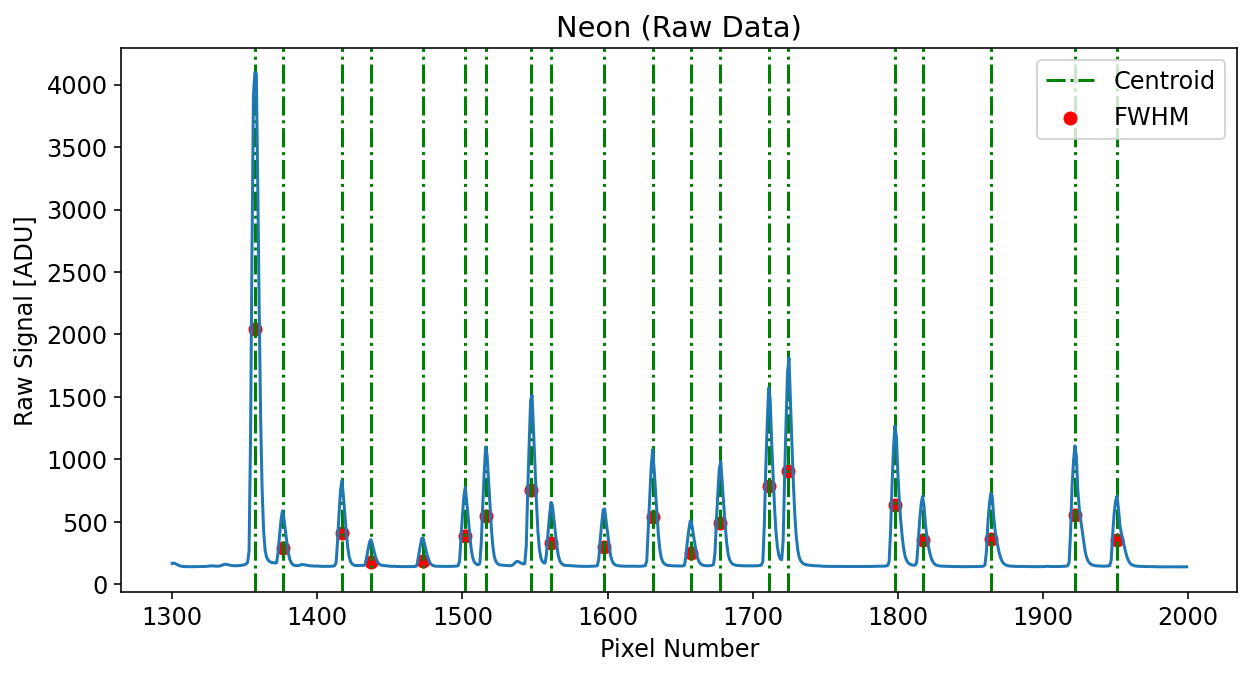

In [27]:
# Centroiding function
#--------------------------------------#
def centroiding(signal_peaks_index, signal_data): # For this function, the first input is the array of peak indeces that was produced in our peak finding function
    CCD_PIXELS = 2048
    pixel = np.arange(0, CCD_PIXELS)
    n_peaks = len(signal_peaks_index)
    centroids = np.zeros((n_peaks,)) # Pixel coordinates for all the centroids
    FWHM = np.zeros((n_peaks,)) # Full-width-half-max signal values for each centroid
    for i in range(n_peaks): # We are using the pixel indeces from our original peak finding function
        peak = signal_peaks_index[i]
        half_max = signal_data[peak] / 2.
        FWHM[i] = (half_max)

        xmin = np.nonzero(signal_data[peak:0:-1] <= half_max)[0][0]
        xmax = np.nonzero(signal_data[peak:-1] <= half_max)[0][0]
        x_range = pixel[peak - xmin:peak + xmax].copy()
        I_range = signal_data[peak - xmin:peak + xmax].copy()
        I_total = np.sum(I_range) # Avoid duplicate calculation
        x_com = np.sum(x_range * I_range / I_total) # x_com stands for X Center of Mass
        centroids[i] = (x_com)
    return centroids, FWHM
#--------------------------------------#


# Calling the function
#--------------------------------------#
neon_centroids, neon_FWHM = centroiding(neon_peaks_index, signal_avg_neon)
#--------------------------------------#


# Plotting
#--------------------------------------#
def plot_vert(x): 
    '''
    Just plots vertical lines, in green dashes, at x-value X
    '''
    plt.axvline(x, color='green', ls='-.')
    # ls specifies the format intuitively
    
for i in neon_centroids[1:]: # Call our plotting function on every centroid except the first
    plot_vert(i)

    
min_pixel = 1300
max_pixel = 2000

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 12})
plt.axvline(centroids_neon[0], color='green', ls='-.', label='Centroid') 
# Reserve the first so I don't have a million "centroid" labels
plt.plot(pixel[min_pixel:max_pixel], signal_avg_neon[min_pixel:max_pixel]) # Plot the actual spectrum
plt.scatter(neon_centroids, neon_FWHM, color='red', marker='o', label='FWHM')
plt.title('Neon (Raw Data)')
plt.xlabel('Pixel Number')
plt.ylabel('Raw Signal [ADU]')
plt.legend()
plt.show()
#--------------------------------------#